In [1]:
import numpy as np
import pandas as pd
from pymc_marketing.clv import utils
from pymc_marketing.clv import ParetoNBDModel
from pymc_marketing.prior import Prior

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pytensor

#set flag to fix open issue
pytensor.config.cxx = '/usr/bin/clang++'

Create a simple dataset for testing:

In [3]:
d = [
    [1, "2015-01-01", 1],
    [1, "2015-02-06", 2],
    [2, "2015-01-01", 2],
    [3, "2015-01-01", 3],
    [3, "2015-01-02", 1],
    [3, "2015-01-05", 5],
    [4, "2015-01-16", 6],
    [4, "2015-02-02", 3],
    [4, "2015-02-05", 3],
    [4, "2015-02-05", 2],
    [5, "2015-01-16", 3],
    [5, "2015-01-17", 1],
    [5, "2015-01-18", 8],
    [6, "2015-02-02", 5],
]
test_data = pd.DataFrame(d, columns=["id", "date", "monetary_value"])

Note customer 4 made two purchases on 2015-02-05. 

`_find_first_transactions` flags the first purchase each customer has made, which must be excluded for modeling. It is called internally by `rfm_summary`.

In [4]:
utils._find_first_transactions(
    transactions=test_data, 
    customer_id_col = "id", 
    datetime_col = "date",
    #monetary_value_col = "monetary_value", 
    #datetime_format = "%Y%m%d",
).reindex()

,id,date,first
0,1,2015-01-01,True
1,1,2015-02-06,False
2,2,2015-01-01,True
3,3,2015-01-01,True
4,3,2015-01-02,False
5,3,2015-01-05,False
6,4,2015-01-16,True
7,4,2015-02-02,False
8,4,2015-02-05,False
10,5,2015-01-16,True


Notice how **9** is missing from the dataframe index. Multiple transactions in the same time period are treated as a single purchase, so the indices for those additional transactions are skipped. 

`rfm_summary` is the primary data preprocessing step for CLV modeling in the continuous, non-contractual domain:

In [5]:
rfm_df = utils.rfm_summary(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
    include_first_transaction=True,
)

rfm_df.head()

,customer_id,frequency,recency,monetary_value
0,1,2.0,0.0,1.5
1,2,1.0,5.0,2.0
2,3,2.0,4.0,4.5
3,4,2.0,0.0,7.0
4,5,1.0,3.0,12.0


For MAP fits and covariate models, `rfm_train_test_split` can be used to evaluate models on unseen data. It is also useful for identifying the impact of a time-based event like a marketing campaign.

In [6]:
train_test = utils.rfm_train_test_split(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    train_period_end = "2015-02-01",
    monetary_value_col = "monetary_value",
)

train_test.head()

,customer_id,frequency,recency,T,monetary_value,test_frequency,test_monetary_value,test_T
0,1,0.0,0.0,31.0,0.0,1.0,2.0,5.0
1,2,0.0,0.0,31.0,0.0,0.0,0.0,5.0
2,3,2.0,4.0,31.0,3.0,0.0,0.0,5.0
3,4,0.0,0.0,16.0,0.0,2.0,4.0,5.0
4,5,2.0,2.0,16.0,4.5,0.0,0.0,5.0


`rfm_segments` will assign customer to segments based on their recency, frequency, and monetary value. It uses a quartile-based RFM score approach that is very computationally efficient, but defining custom segments is a rather subjective exercise. The returned dataframe also cannot be used for modeling because it does not zero out the initial transactions.

In [7]:
segments = utils.rfm_segments(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
)

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/utils.py:707: UserWarning: RFM score will not exceed 2 for f_quartile. Specify a custom segment_config
  warnings.warn(


### Functions Requiring a Fitted Model
`expected_cumulative_transactions` and all plotting functions require a fitted model:

In [8]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"
raw_trans = pd.read_csv(url_cdnow)

rfm_data = utils.rfm_summary(
    raw_trans, 
    customer_id_col = "id", 
    datetime_col = "date", 
    datetime_format = "%Y%m%d",
    time_unit = "W",
    observation_period_end = "19970930",
    #time_scaler = 7,
)

pnbd = ParetoNBDModel(data=rfm_data)

pnbd.fit()

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [9]:
from pymc_marketing.clv import plot_purchase_pmf

Sampling: [alpha, beta, r, recency_frequency, s]


<Axes: title={'center': 'Prior Predictive Check of Repeat Purchases per Customer'}, xlabel='Repeat Purchases per Customer', ylabel='Percent of Purchases'>

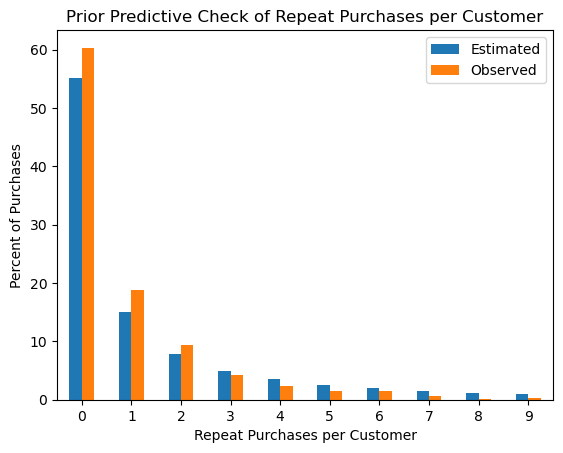

In [10]:
plot_purchase_pmf(pnbd, ppc='prior')

In [11]:
# pnbd.build_model()
# with pnbd.model:
#     pnbd.idata = pm.sample(
#         step=pm.DEMetropolisZ(),
#         tune=2500,
#         draws=3000,
#         idata_kwargs={"log_likelihood": True},
#     )

# keep n_samples=1
pnbd.distribution_new_customer_recency_frequency(
        random_seed=45,
        n_samples=1,
    ).sel(obs_var="frequency")


Sampling: [recency_frequency]


Output()

<xarray.DataArray 'recency_frequency' (chain: 1, draw: 1, customer_id: 2357)> Size: 19kB
array([[[1., 3., 0., ..., 0., 1., 0.]]])
Coordinates:
  * chain        (chain) int64 8B 0
  * draw         (draw) int64 8B 0
  * customer_id  (customer_id) int64 19kB 1 2 3 4 5 ... 2353 2354 2355 2356 2357
    obs_var      <U9 36B 'frequency'

In [40]:
import pymc as pm
import xarray as xr

# TODO: Add build_model() before a prior predictive check
pnbd.build_model()
with pnbd.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, samples=100)

# obs_var must be obtained from  prior_idata in case of an unfit model
obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")#.mean(("chain","draw"))
#ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency").mean(("chain","draw"))#.rename({o

ppc_df = ppc_freq.to_dataframe()['recency_frequency'].value_counts(normalize=True).sort_index() * 100

# Percentages are the only way to compare actual counts to chain*draw simulated counts
# merged_xr.to_dataframe()["recency_frequency"].value_counts(normalize=True) * 100
# merged_xr.to_dataframe()["ppc_mean"].value_counts(normalize=True) * 100

Sampling: [alpha, beta, r, recency_frequency, s]


<Axes: >

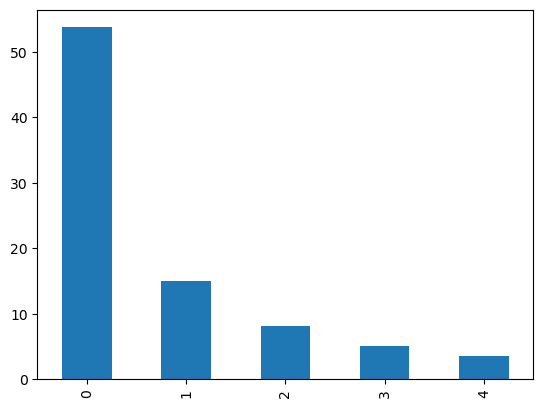

In [53]:
ppc_df.reset_index()['proportion'].head(5).plot(kind='bar')

HDIs are much more difficult to add. Value counts must be performed across a dimension, and it is on this Dataset which the HDI can then be calculated

In [16]:
from xarray.groupers import UniqueGrouper

# This will do value counts for entire DataArray
#ppc_freq.groupby(ppc_freq).count()
#ppc_freq.groupby(chain=UniqueGrouper()).count()

#value_counts = xr.DataArray(np.bincount(ppc_freq.values), dims="value")
#np.bincount(ppc_freq.values)
xr.DataArray([1, 2, 2, 3, 3, 3], dims="x")
# but what about individual customers?
# create a value count coordinate
# prior_idata.prior_predictive.coords["value_counts"] = ppc_freq.groupby(ppc_freq).count()["ppc_mean"].values
# ppc_freq = prior_idata.rename_vars({"recency_frequency":"ppc_mean"}).prior_predictive["ppc_mean"]#.sel(obs_var="frequency")#.mean(("chain","draw"))
# ppc_freq
# prior_idata.prior_predictive.groupby(value_counts=UniqueGrouper()).count().sel(obs_var="frequency")
#prior_idata.prior_predictive.groupby("customer_id").count()
#prior_idata# 
#
# #ppc_freq.coords["grouped_customer"] 
#ppc_freq.groupby(draw=UniqueGrouper()).count()


<xarray.DataArray (x: 6)> Size: 48B
array([1, 2, 2, 3, 3, 3])
Dimensions without coordinates: x

In [64]:
from arviz.stats import hdi

calc_hdi = hdi(
    ary=prior_idata,
    hdi_prob=.9, #param
    group='prior_predictive', #posterior
).sel(obs_var='frequency')

hdi_lo = calc_hdi.sel(hdi='lower').to_array().squeeze()
hdi_hi = calc_hdi.sel(hdi='higher').to_array().squeeze()

# TODO: Join back to ppc_freq & obs var
hdi_hi

<xarray.DataArray (customer_id: 2357)> Size: 19kB
array([6., 5., 9., ..., 6., 6., 6.])
Coordinates:
  * customer_id   (customer_id) int64 19kB 1 2 3 4 5 ... 2354 2355 2356 2357
    obs_var       <U9 36B 'frequency'
  * value_counts  (value_counts) float64 1kB 0.0 1.0 2.0 ... 176.0 178.0 186.0
    hdi           <U6 24B 'higher'
    variable      <U17 68B 'recency_frequency'

### `expected_cumulative_transactions`

In [ ]:
df_cum = utils._expected_cumulative_transactions(
    model=pnbd,
    transactions=raw_trans,
    customer_id_col="id",
    datetime_col="date",
    t=25*7,
    datetime_format="%Y%m%d",
    time_unit="W",
    set_index_date=True,
)

df_cum.info()

In [10]:
df_cum

,actual,predicted
1996-12-30/1997-01-05,0,4.232350
1997-01-06/1997-01-12,3,15.415502
1997-01-13/1997-01-19,17,33.593211
1997-01-20/1997-01-26,44,59.287376
1997-01-27/1997-02-02,67,92.716297
...,...,...
2000-04-03/2000-04-09,4004,6563.077204
2000-04-10/2000-04-16,4004,6586.673815
2000-04-17/2000-04-23,4004,6610.195558
2000-04-24/2000-04-30,4004,6633.643085
